In [ ]:
%pip install 'bkng-ml-rs' --index-url https://jfrog.booking.com/artifactory/api/pypi/pypi/simple

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [ ]:
import json
from bkng.mlregistry.client.types.entities import Application, Asset
from bkng.mlregistry.client.types.asset_type import AssetType
from bkng.ml.rs.client.gen_ai import Message

from bkng.ml.rs.client import GenAIClient

# Please replace with your own ML Application name and version here
application = Application(name='taylor-agent-poc')
claude = Asset(asset_type=AssetType.STATIC_MODEL, name='claude_3_5_sonnet', version='0.0.1')

In [ ]:
genai_client = GenAIClient()

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)

In [5]:
from langchain_core.messages import (
    AIMessageChunk,
    FunctionMessageChunk,
    HumanMessageChunk,
    SystemMessageChunk,
    ToolMessageChunk,
)

In [ ]:
from typing import Any, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
)
from langchain_core.messages.ai import UsageMetadata
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from pydantic import Field


class ChatParrotLink(BaseChatModel):
    """A custom chat model that echoes the first `parrot_buffer_length` characters
    of the input.

    When contributing an implementation to LangChain, carefully document
    the model including the initialization parameters, include
    an example of how to initialize the model and include any relevant
    links to the underlying models documentation or API.

    Example:

        .. code-block:: python

            model = ChatParrotLink(parrot_buffer_length=2, model="bird-brain-001")
            result = model.invoke([HumanMessage(content="hello")])
            result = model.batch([[HumanMessage(content="hello")],
                                 [HumanMessage(content="world")]])
    """

    model_name: str = Field(alias="model")
    """The name of the model"""
    parrot_buffer_length: int
    """The number of characters from the last message of the prompt to be echoed."""
    temperature: Optional[float] = None
    max_tokens: Optional[int] = None
    timeout: Optional[int] = None
    stop: Optional[List[str]] = None
    max_retries: int = 2

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        """Override the _generate method to implement the chat model logic.

        This can be a call to an API, a call to a local model, or any other
        implementation that generates a response to the input prompt.

        Args:
            messages: the prompt composed of a list of messages.
            stop: a list of strings on which the model should stop generating.
                  If generation stops due to a stop token, the stop token itself
                  SHOULD BE INCLUDED as part of the output. This is not enforced
                  across models right now, but it's a good practice to follow since
                  it makes it much easier to parse the output of the model
                  downstream and understand why generation stopped.
            run_manager: A run manager with callbacks for the LLM.
        """
        # Replace this with actual logic to generate a response from a list
        # of messages.
        last_message = messages[-1]
        tokens = last_message.content[: self.parrot_buffer_length]
        genai_client.chat_completion(
                application=application,
                model=claude,
                messages=[
                    Message(role="user", content=["What's the weather in Amsterdam?"]),
                ],
                parameters={
                    'max_tokens': 100,
                },
            )
        ct_input_tokens = sum(len(message.content) for message in messages)
        ct_output_tokens = len(tokens)
        message = AIMessage(
            content=tokens,
            additional_kwargs={},  # Used to add additional payload to the message
            response_metadata={  # Use for response metadata
                "time_in_seconds": 3,
            },
            usage_metadata={
                "input_tokens": ct_input_tokens,
                "output_tokens": ct_output_tokens,
                "total_tokens": ct_input_tokens + ct_output_tokens,
            },
        )
        ##

        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])

    # def _stream(
    #     self,
    #     messages: List[BaseMessage],
    #     stop: Optional[List[str]] = None,
    #     run_manager: Optional[CallbackManagerForLLMRun] = None,
    #     **kwargs: Any,
    # ) -> Iterator[ChatGenerationChunk]:
    #     """Stream the output of the model.

    #     This method should be implemented if the model can generate output
    #     in a streaming fashion. If the model does not support streaming,
    #     do not implement it. In that case streaming requests will be automatically
    #     handled by the _generate method.

    #     Args:
    #         messages: the prompt composed of a list of messages.
    #         stop: a list of strings on which the model should stop generating.
    #               If generation stops due to a stop token, the stop token itself
    #               SHOULD BE INCLUDED as part of the output. This is not enforced
    #               across models right now, but it's a good practice to follow since
    #               it makes it much easier to parse the output of the model
    #               downstream and understand why generation stopped.
    #         run_manager: A run manager with callbacks for the LLM.
    #     """
    #     last_message = messages[-1]
    #     tokens = str(last_message.content[: self.parrot_buffer_length])
    #     ct_input_tokens = sum(len(message.content) for message in messages)

    #     for token in tokens:
    #         usage_metadata = UsageMetadata(
    #             {
    #                 "input_tokens": ct_input_tokens,
    #                 "output_tokens": 1,
    #                 "total_tokens": ct_input_tokens + 1,
    #             }
    #         )
    #         ct_input_tokens = 0
    #         chunk = ChatGenerationChunk(
    #             message=AIMessageChunk(content=token, usage_metadata=usage_metadata)
    #         )

    #         if run_manager:
    #             # This is optional in newer versions of LangChain
    #             # The on_llm_new_token will be called automatically
    #             run_manager.on_llm_new_token(token, chunk=chunk)

    #         yield chunk

    #     # Let's add some other information (e.g., response metadata)
    #     chunk = ChatGenerationChunk(
    #         message=AIMessageChunk(content="", response_metadata={"time_in_sec": 3})
    #     )
    #     if run_manager:
    #         # This is optional in newer versions of LangChain
    #         # The on_llm_new_token will be called automatically
    #         run_manager.on_llm_new_token(token, chunk=chunk)
    #     yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            # The model name allows users to specify custom token counting
            # rules in LLM monitoring applications (e.g., in LangSmith users
            # can provide per token pricing for their model and monitor
            # costs for the given LLM.)
            "model_name": self.model_name,
        }

In [7]:
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

llm = ChatParrotLink(parrot_buffer_length=3, model="my_custom_model")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

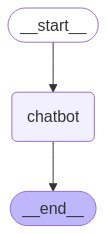

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

i=0
while True and i<10:
    i+=1
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: 
Assistant: weq
Assistant: wqe
